# 프로젝트: KoChatGPT 업그레이드 하기

아래 제시된 전략 중 하나를 선택하거나 여러 개를 조합하여 여러분만의 custom ChatGPT를 개발해보자. 

    1. 이전 노드에서 KoChatGPT에서 사용한 데이터셋을 더 정제하기
    2. Human Feedback이 반영된 데이터셋 대체; SFT와 RM 모델에 사용한 다양한 benchmark 데이터셋 검토
    3. 최선의 디코딩을 위한 하이퍼파라미터 서치
    4. 생성된 답변에 대한 주관적인 평가를 보완할 수 있는 정략적인 메트릭 도입
    5. 다양한 Instruction Tuning 및 Prompting 기법 적용
    6. 더 큰 파라미터 스케일을 가진 모델 사용
    7. 더 효율적인 연산을 수행하는 LoRA 적용 또는 새로운 Instruction Tuning 및 reward ranking 알고리즘 도입
    


Reinforcement Learning from Human Feedback(RLHF): 강화 학습의 한 방법론으로, 사람의 피드백을 직접적인 보상으로 사용하여 모델을 학습.

  1. 사람(human demonstrator)이 어떤 작업을 수행하는 것을 관찰하거나, 모델의 행동에 대한 피드백을 직접 제공.
  2. 사람의 피드백을 바탕으로 '보상 모델'을 구축. 
  3. 이 보상 모델을 사용하여 강화학습 알고리즘을 통해 모델을 학습
  
SFT로 초기 학습을 시작하고, RM을 통해 보상을 구하며, PPO를 사용하여 이 보상을 최대화하는 방향으로 모델을 학습시킨다. 

## STEP 0. 환경 만들기

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## STEP 1. tokenizer 및 model 불러오기

In [2]:
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### tokenizer 

In [3]:
#모델별 최대 입력 크기
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

In [4]:
# 토크나이저 테스트
input_txt = "바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."

tokens = tokenizer(input_txt).tokens() #토큰화
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].numpy()  #각 토큰의 ID

#토큰과 해당 ID를 매칭
pd.options.display.max_columns = 40
pd.options.display.max_rows = 60
df = pd.DataFrame([tokens, input_ids[0]], index=["kogpt-2_tokens", "Input_IDs"])
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
kogpt-2_tokens,▁바람,도,▁없는,▁공중에,▁수직,의,▁파,문을,▁내,이며,▁고,요,히,▁떨어지는,▁오동,잎은,▁누,구의,▁발자,취,▁입,니까,.
Input_IDs,10891,7235,9712,49207,14438,8143,9203,9941,9094,9639,9065,8084,8811,21215,34769,19985,9669,10139,21626,8408,9241,23775,389


### decoder

In [5]:
max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

#Beam Search Decooding
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2, do_sample=False)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇지 않습니다."
"어떻게 된 일입니까?"
그녀는 고개를 갸웃거렸다.
"아니, 그게 무슨 말씀이신지 모르겠습니다만."
"무슨 말씀인지 알 수가 없군요."
아무런 대답도 하지 않은 채 그녀는 고개를 끄덕였다.
"그래, 알았어."
그녀의 눈에서 눈물이 주르륵 흘러내렸다.
그녀가 다시 입을 열었다.
"정말 죄송합니다, 고마워요, 고맙습니다"
"


In [6]:
# 샘플링 기법 추가 - top_k
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2, do_sample=True, temperature=2.0, top_k=50)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."
"하하, 너는 어디에 있니? 네가 어디로 간다고 말했단 말야?"
눈물이 고여 울고 있었다.
"누구, 어디로 갔나? 너의 이름을 알지도 못하면서 네 이름만 댔으니."
"네 말이 맞다. 하지만 나는 너한테 그런 말을 해본 적이 없단 말이야. 그저 네 이름을 잘 기억 못 할 뿐이라고. 내가 알고 있는 거라고는 내가 아니라 너밖에 없다고. 그래서 그렇게 말한 것 아니냐고. 그게 뭔지는 모르겠지만


In [7]:
# 샘플링 기법 추가 - top_p
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2, do_sample=True, top_p=0.90)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇겠지요."
"아니오. 그게 무슨 소리요?"
그녀는 고개를 끄덕였다.
"어떻게 된 일입니까, 선생님? 그건 그렇고."
"선생님, 저는 잘 모르겠습니다."
선생님은 한숨을 내쉬었다.
"그래서 선생님을 만나기로 했어요. 선생님이 저를 만나고 싶다고 하셨거든요. 그런데 선생님은 저에게 아무 말도 하지 않으시더군요. 왜 그러십니까? 저도 선생


## STEP 2. EDA 및 데이터 정제

### Supervised Fine Tuning(SFT) 데이터셋

SFT: human demonstrator가 원하는 대답을 제공하면, 이 데이터를 사용하여 미세조정하여 모델을 사전학습 시킴. 

In [8]:
#데이터 로드
import os
import json 

HOME_DIR = os.getenv('HOME')

data_path_1_SFT = HOME_DIR + '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict= json.load(json_file)

In [9]:
#데이터 확인
import pandas as pd

df_sft = pd.DataFrame(list_data_dict)
df_sft.head()

,prompt,completion,tokens
0,불고기용 고기 한우에요?,"'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하...",193
1,쓰던 앱이 유료로 전환됐어,"'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 ...",288
2,여친이랑 다툼,'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하...,153
3,술 먹고 싶어,"'술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 ...",189
4,잊고싶다.,'저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 ...,147


prompt: 사람이 한 질문

completion: 모델이 생성한 답변

tokens: 총 토큰 수 

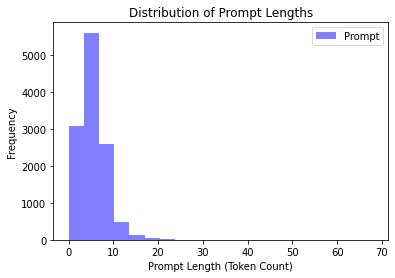

In [10]:
#데이터('prompt'와 'completion') 길이 분포
import matplotlib.pyplot as plt

df_sft['prompt_length'] = df_sft['prompt'].apply(lambda x: len(x.split()))

plt.hist(df_sft['prompt_length'], bins=20, color='blue', alpha=0.5, label='Prompt')
plt.xlabel('Prompt Length (Token Count)')
plt.ylabel('Frequency')
plt.title('Distribution of Prompt Lengths')
plt.legend()
plt.show()

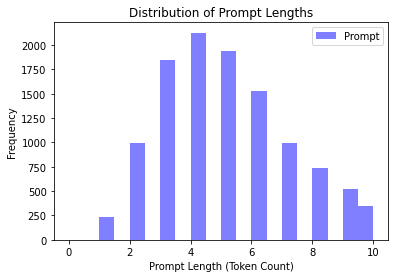

In [11]:
# 토큰 수가 10보다 큰 'prompt' 데이터 제거한 데이터 길이 분포
df_sft = df_sft[df_sft['prompt'].apply(lambda x: len(x.split()) <= 10)]

df_sft['prompt_length'] = df_sft['prompt'].apply(lambda x: len(x.split()))

plt.hist(df_sft['prompt_length'], bins=20, color='blue', alpha=0.5, label='Prompt')
plt.xlabel('Prompt Length (Token Count)')
plt.ylabel('Frequency')
plt.title('Distribution of Prompt Lengths')
plt.legend()
plt.show()

### Reward Model(RM) 데이터셋

RM: 사람의 피드백을 바탕으로 구축된 보상 모델

여러 출력 후보를 사람에게 제시하고, 그 사람이 어느 것이 더 나은지를 평가한다. 

이 평가를 통해 모델의 출력에 대한 보상을 생성한다. 

In [12]:
#데이터 로드
data_path_2_RM = HOME_DIR + '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

In [13]:
#데이터 확인
import pandas as pd

df_rm = pd.DataFrame(list_data_dict)
df_rm.head()

,prompt,completion_0,completion_1,completion_2,ranking
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독...",Allow me to answer your question. I know that ...,번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.,라이언에게 말했다.,"[2, 1, 0]"
1,개포주공아파트는 몇 단지로 이루어져 있나?,개포주공아파트는 다섯 단지로 이루어져 있습니다.,이날 목송에서 구글상위노,개포주공아파트는 총 27개 단지로 이루어져 있습니다.,"[2, 0, 1]"
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?,The diameter of the Metallic domain is bigger ...,"이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가...",김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 ...,"[1, 2, 0]"
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야,"1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 ...","- 아랍요리는 소금, 산 재료, 일부 채소, 고기, 생선 또는 난류의 조합으로 만들...",위한 태야 대표 기원들 개인이라 겪고 태야\n\n\n귀식 걸 공개한 구문\n\n사띩...,"[0, 1, 2]"
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?,중화인민공화국의 기본 법률은 중국인민대표대회(국회)가 제정하고 개정합니다.,The limit of the Office of the Vice President is?,중화인민공화국의 기본 법률은 중화인민공화국의 의회가 제정 및 개정합니다.,"[0, 2, 1]"


prompt: 사람이 한 질문

completion_0, 1, 2: 여러 모델의 답변

ranking: 사람이 정한 각 답변의 품질 순위

### Proximal Policy Optimization (PPO) 데이터셋

PPO: 강화 학습 알고리즘

SFT로 미세 조정된 모델을 PPO를 사용하여 추가로 학습시킨다. 

이때, 위에서 구축된 RM을 사용하여 모델을 학습시킨다. 

In [14]:
#데이터 로드
data_path_3_PPO = HOME_DIR + '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict= json.load(json_file)

In [15]:
#데이터 확인
import pandas as pd

df_ppo = pd.DataFrame(list_data_dict)
df_ppo.head()

,prompt
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독..."
1,개포주공아파트는 몇 단지로 이루어져 있나?
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?


prompt: 사람이 한 질문

## STEP 3-1. SFT

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### 모델과 토크나이저

In [17]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2',
                                          bos_token='</s>',     # 시작 토큰
                                          eos_token='</s>',     # 종료 토큰
                                          unk_token='</s>',     # OOV 토큰
                                          pad_token='</s>',     # 패딩 토큰
                                          padding_side="right", # 패딩 방향
                                          model_max_length=512, # 입력 문장 최대 길이
                                         )

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


### 데이터셋

In [18]:
from typing import Optional, Dict, Sequence


class SFT_dataset(Dataset): 
    
    def __init__(self, 
                 data_path_1_SFT: str, # SFT 데이터 위치
                 tokenizer: transformers.PreTrainedTokenizer,
                 verbose=False,
                ):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        # column 이름
        pattern_instruction = 'prompt' # instruction
        pattern_output = 'completion' # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        # 지시문
        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }
        prompt_input = PROMPT_DICT["prompt_input"]

        # 전처리
        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example) # 지시문 추가
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}") # 종료 토큰 추가
        examples = [s + t for s, t in zip(sources, targets)] # 질문 문장과 대답 문장 연결

        # 토큰화
        sources_tokenized = self._tokenize_fn(sources, tokenizer)  
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  

        # 정수화
        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100 

        # 데이터셋 생성
        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, 
                     strings: Sequence[str], # 토큰화할 문장 리스트
                     tokenizer: transformers.PreTrainedTokenizer, 
                    ) -> Dict:
        """
        문장을 토큰화해 시퀀스 정보를 딕셔너리에 담아 변환
        """
        # 문장 토큰화
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        
        # 정수 시퀀스
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        
        # 시퀀스 길이
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() # pad_token이 아닌 토큰 개수
            for tokenized in tokenized_list
        ]
        
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        """
        데이터셋 크기 반환
        """
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        """
        데이터셋의 샘플 반환
        """
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [19]:
# attention mask 추가
@dataclass
class DataCollatorForSupervisedDataset(object): 
    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [20]:
SFT_DATASET_PATH = HOME_DIR + '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl'

train_dataset = SFT_dataset(data_path_1_SFT=SFT_DATASET_PATH, tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914,   382, 37767, 13753,  8263,  7166,   739,  8352,  7659,
         9594, 25585, 13600,  8022,  9378, 11532,  9887, 11218,  9111, 16691,
        10351, 10561,  9128, 20479,  8091,  9065,  9446,  9036, 28420, 26521,
        10163, 26367,  6958,  9030,  9882, 12317, 25882,  9209, 37194, 10351,
         9036, 12168, 10529, 15989,  9719, 15434, 10552, 11188, 13362,  9036,
        15805, 11300, 11846,  9146, 16691,  9181,  7397, 15806, 13480, 11342,
        17596,  9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,
         8711,  9046, 12450,  9117,  7377, 12521,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

### Trainer

In [21]:
training_args = TrainingArguments(
    output_dir="aiffel/KoChatGPT/test", #저장 위치
    overwrite_output_dir=True, #덮어 쓰기
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,#학습률을 0에서 시작하여 원하는 최대 학습률까지 선형적으로 증가
    prediction_loss_only=True, #prediction loss만 계산하여 반환
    fp16 = True  #16비트 부동 소수점 연산을 사용
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

### 학습

In [22]:
trainer.train()
model.save_pretrained('/aiffel/KoChatGPT/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.984100
1000,2.776800
1500,2.687200


### 학습 결과 확인

In [23]:
#텍스트 생성을 위한 파이프라인 설정 
generator = pipeline('text-generation', model='aiffel/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

#텍스트 생성 시 사용될 파라미터 설정
generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0, #반복적으로 동일한 단어나 구를 생성하는 것을 억제 
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

#지시문
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

#사용자가 모델에게 던질 질문 리스트
list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

#각 질문 앞에 지시문이 추가
list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

#각 질문과 그에 대한 응답을 출력
list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 불고기용 고기의 종류와 양에 대한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기는 쇠고기와 함께 먹는 음식 중 하나입니다. 따라서 불고기를 먹을 수 있는 종류는 다양합니다. 예를 들어, 닭가슴살 스테이크, 오므라이스 샐러드 등이 있습니다.

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 42대 부통령직을 수행했습니다.作)作)은 "리처드 닉슨"이 41대 부통령을 수행한 년도를 가리키는 말입니다.作)는 "리처드 닉슨"이 40대 부통령을 맡았던 년도를 의미합니다.作은 "리처드슨"이 50대 부통령

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오 헤어 국제공항은 미국 캘리포니아주 샌프란시스코에 위치해 있습니다.子供共和國際空港)이라고 불립니다.子供公和国際空港이라는 뜻입니다.子供空和國際公港이라는 이름을 가진 항공사는 다음과 같습니다.\n\n1. 대한항공

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 챗봇으로써 미세먼지 정보를 알 수 없습니다. 미세먼지 예보를 확인해 보시는 것이 좋겠습니다.\n\n미세먼지 예보: 일반적으로 미세먼지는 주로 중국에서 발원하여 중국 전역으로 퍼져나가기 때문에 중국발 미세먼지가 유입될


In [24]:
#GPU 메모리 초기화
#torch.cuda.empty_cache()

## STEP 3-2. RM

In [25]:
#pip install chatgpt

In [26]:
#!pip install "$HOME/aiffel/KoChatGPT/colossalai_ChatGPT_230319/"

In [27]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

### 모델 클래스 정의

In [28]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0, #LoRA 적용시 사용되는 rank 수
                 lora_train_bias: str = 'none', #LoRA 적용 시 사용되는 학습 bias 방식 적용 
                 tokenizer=None) -> None:
        if pretrained is not None:
            #지정된 pretrained 모델 불러오기
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            #지정된 config를 적용하여 GPT2 모델 불러오기
            model = GPT2Model(config)
        else:
            #기본 설정의 GPT2 모델 불러오기
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()
        
        #reward가 스칼라값으로 출력되도록 설정
        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)
        
        #모델 멤버 변수에 모델 객체를 저장
        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

### 모델 및 토크나이저

In [29]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### 데이터셋

In [30]:
with open(HOME_DIR + '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    # 랭킹이 높은 답변을 chosen으로 저장
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)

    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


In [31]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은?', 'chosen': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은 류승완의 사무실입니다.', 'rejected': '대구 영화사옥'}


In [32]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

1000
200


100%|██████████| 200/200 [00:00<00:00, 1015.71it/s]


In [33]:
# 데이터셋 확인 
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
흑고래의 무게는 어느 정도야
######################################################################
## chosen ##
흑고래의 평균 몸무게는 약 25~40톤 정도이지만, 최대 몸무게는 50톤 이상에 이를 수 있습니다.
######################################################################
## rejected ##
흑고래의 무게는 매우 다양하게 달라집니다. 약 200kg에서 10톤까지 달라질 수 있습니다.


### Trainer

In [34]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

### 학습

In [35]:
trainer.fit(use_lora=0)

model.save_pretrained('/aiffel/KoChatGPT/output_2_RM')

Train epoch: 100%|██████████| 1/1 [03:51<00:00, 231.31s/it]


### 학습 결과 확인

In [36]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

In [37]:
input_text = '인공지능은 똥멍청이 입니다'

output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: -0.6


In [38]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.
reward score: -0.6


In [39]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다.
reward score: -0.4


In [40]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다.
reward score: -0.3


In [41]:
#GPU 메모리 초기화
#torch.cuda.empty_cache()

## STEP 3-3. PPO

In [42]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

### 모델과 토크나이저

In [43]:
with NaiveStrategy().model_init_context():
    # actor, 문장을 생성할 SFT된 모델
    actor = GPTActor(pretrained='/aiffel/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    # critic, 생성된 문장을 reward 값으로 평가할 RM
    critic = GPTCritic(pretrained='/aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )
    
    #비교 모델
    initial_model = deepcopy(actor)
    #PPO로 학습할 모델
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [44]:
#actor와 critic의 옵티마이저
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [45]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

### 데이터셋

In [46]:
with open(HOME_DIR + '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [47]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [48]:
len(list_prompt)

12000

### Trainer

In [49]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

### 학습

In [50]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('/aiffel/KoChatGPT/output_3_PPO')

Episode [10/10]: 100%|██████████| 3/3 [00:17<00:00,  5.78s/it]


### 학습 결과 확인

In [51]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 챗봇이므로 제가 어떤 종류의 쇠고기를 판매하는지 알 수 없습니다. 죄송합니다. srkin (쇠고기) 추가 정보가 필요합니다. 불고기용 한우는 불고기용 부위를 말합니다. geos, 또는 kinhungsin에서 각각 다른 이름입니다. geos, 또는 geos, 혹은 kinhungsin에서는 다양한 이름으로 사용됩니다. geos, 또는  Kinhungsin은 각각 다른 이름으로 사용되기도 합니다.  ninglawaid에서 각각 다른 이름으로 사용될 수 있습니다. geos, 또는  Ninglawaid에서는 주로 불고기용으로 사용되는 경우가 많습니다. geos, 또는 geos는 각각 다른 이름으로 사용될 수 있습니다. geos, 또는 geos는 각각 다른 이름으로 쓰일 수 있습니다. geos, 또는 geos는 각각 다른 이름으로 사용되기도 합니다. neos, 또는 

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):"저는 데이터에 대한 의존도를 가지고 있지 않기 때문에 제임스 닉슨의 부통령직에서 근무한 기간도에 대해 알지 못합니다. 정확한 정보와 관련해서는 "리처드 닉슨의 47대 부통령직"이라는 개인의 이름이나 연도, 인물 정보에 대한 정보가 없습니다.", 'token': 147}自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由自由

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어

### Response(응답):'저는 인공지능 챗봇이므로 시카고에 있는 국제공항 정보나 위치 정보가 없습니다. 하지만 현재 시카고에는 수많은 공항이 있으므로 

## 회고

강화모델은 처음 공부해서 공부하는데 시간이 오래 걸렸다. (개인적으로 함수화 코드가 약한데, 이번엔 함수화 코드 분량이 많아서 더 오래 걸리기도 했다.)
이전에는 naive하게 모델까지 짰다면 최근엔 전이학습을 위주로 하여 데이터를 정제하거나 fine tuning하는 걸 하고 있어서 포기하지 않고 끝까지 마무리할 수 있었다. (샤라웃 투 챗지피티)

학습을 진행하는 과정 중에 저장된 학습 모델을 불러오는데 반복적인 오류가 발생했다. (사실 지금도 발생해서 다시 코드를 돌리는 와중에 회고를 작성하고 있는 중이다.) 디렉토리를 설정하는 과정에서 같은 이름을 중복하다가 발생한 것으로 추정된다. 비슷한 과정을 반복하더라도 이름을 다르게 하는 습관을 들일 필요가 있어보인다. 